In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from cvx.covariance.ewma import iterated_ewma
from cvx.covariance.covariance_combination import CovarianceCombination
from experiments.utils.experiment_utils import add_to_diagonal, log_likelihood, ecdf

sns.set()
sns.set(font_scale=1.5)

In [2]:
returns = pd.read_csv('../../data/SP500_top25_adjusted.csv', index_col=0, parse_dates=True)

# Risk-free rate
FF = pd.read_csv('../../data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

In [30]:
pairs = [(10, 21), (21, 63), (63, 125), (125, 250), (250, 500)]

# compute the covariance matrices, one time series for each pair
iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], clip_at=10000, min_periods_vola=63, min_periods_cov=63, mean=True)) for pair in pairs}
means = {key: {item.time: item.mean for item in iewma} for key, iewma in iewmas.items()}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}

Sigmas["10-21"] = add_to_diagonal(Sigmas["10-21"], lamda=0.05)

In [31]:
combinator = CovarianceCombination(Sigmas=Sigmas, returns=returns, means=means)
results = list(combinator.solve_window(window=10, verbose=True))

100%|██████████| 3138/3138 [00:34<00:00, 90.08it/s] 


In [32]:
from collections import namedtuple

pred = namedtuple("pred", ["time", "mean", "covariance", "weights"])

cm_iewma_mean = {result.time: result.mean for result in results}
cm_iewma_cov = {result.time: result.covariance for result in results}
weights = {result.time: result.weights for result in results}
times = [result.time for result in results]

cm_iewma = pred(times, cm_iewma_mean, cm_iewma_cov, weights)

In [33]:
# Prescient 
covs = {}
means = {}
times = []
for t in returns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    cov = np.cov(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, rowvar=False)
    mean = returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].mean().values
    covs[t] = pd.DataFrame(cov, index=returns.columns, columns=returns.columns)
    means[t] = pd.Series(mean, index=returns.columns)
    times.append(t)
prescient = pred(times, means, covs, None)

# Experiments

In [34]:
# Define start and end of backtest; first two years used for training/burn-in
start_date = pd.to_datetime("2011-12-28", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

In [35]:
names = ["CM-IEWMA", "PRESCIENT"]

times = [t for t in cm_iewma.time if t >= start_date and t <= end_date]
means = {t: cm_iewma.mean[t] for t in times}
covariances = {t: cm_iewma.covariance[t] for t in times}
weights = {t: cm_iewma.weights[t] for t in times}
cm_iewma = pred(times, means, covariances, weights)

times = [t for t in prescient.time if t >= start_date and t <= end_date]
means = {t: prescient.mean[t] for t in times}
covariances = {t: prescient.covariance[t] for t in times}
prescient = pred(times, means, covariances, None)


predictors = [cm_iewma, prescient]

# CM-IEWMA component weights

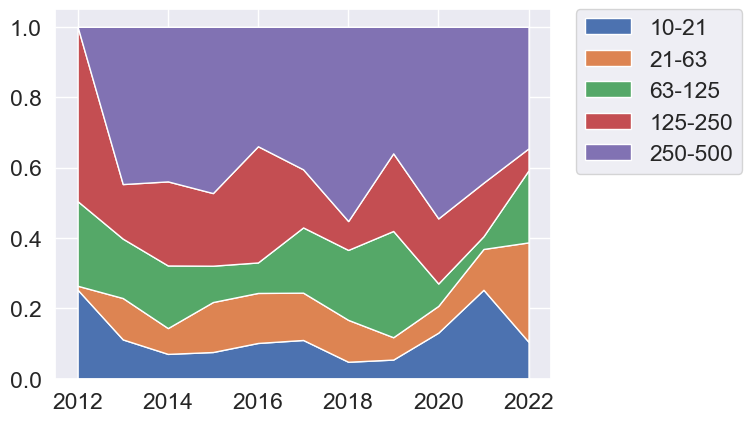

In [36]:
quarterly_weights  = pd.DataFrame(cm_iewma.weights).T.resample("Y").mean().loc[start_date:end_date]

plt.stackplot(quarterly_weights.index, quarterly_weights.values.T, labels=["10-21", "21-63", "63-125", "125-250", "250-500"])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

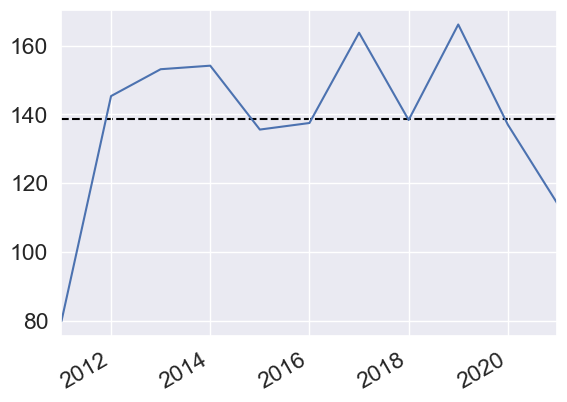

In [37]:
halflifes_vola = np.array([10, 21, 63, 125, 250])
(quarterly_weights * halflifes_vola).sum(axis=1).plot()
plt.axhline((quarterly_weights * halflifes_vola).sum(axis=1).mean(), color="black", linestyle="--", label="Mean half-life", zorder=-1);
plt.gcf().autofmt_xdate()

# Log likelihoods

In [38]:
log_likelihoods = {}

for i, predictor in enumerate(predictors):
    print("Computing " + names[i] + " log-likelihood...")
    

    times = predictor.time
    returns_temp = returns.loc[times].values[1:]
    means_temp = np.stack([predictor.mean[t].values for t in times])[:-1]
    Sigmas_temp = np.stack([predictor.covariance[t].values for t in times])[:-1]

    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp, means=means_temp), index=times[1:])


regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]

Computing CM-IEWMA log-likelihood...
Computing PRESCIENT log-likelihood...


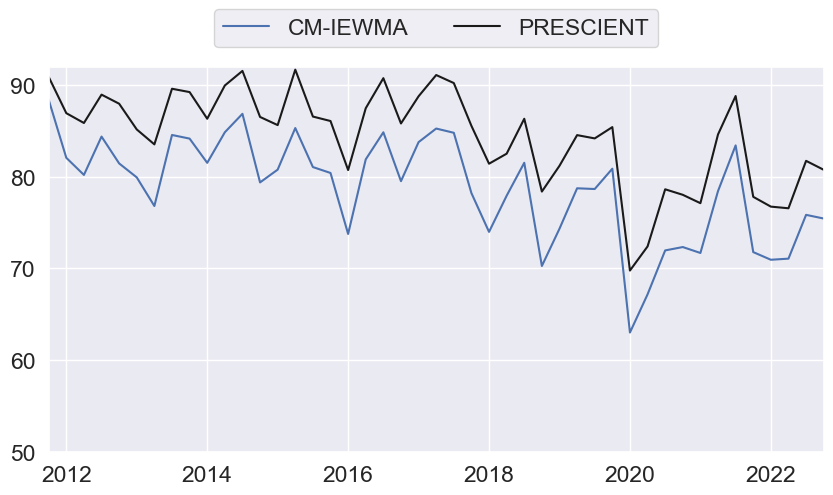

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        log_likelihoods[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5);
plt.ylim(50,92);

# Regrets

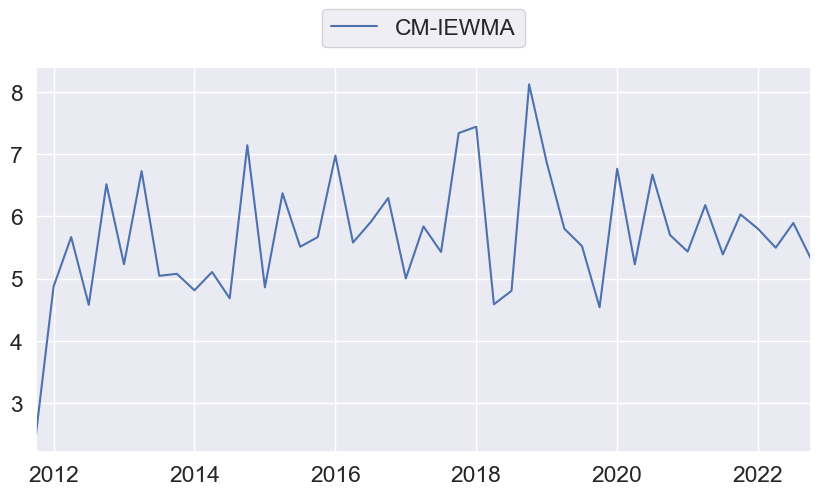

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);


### Regret CDF plots

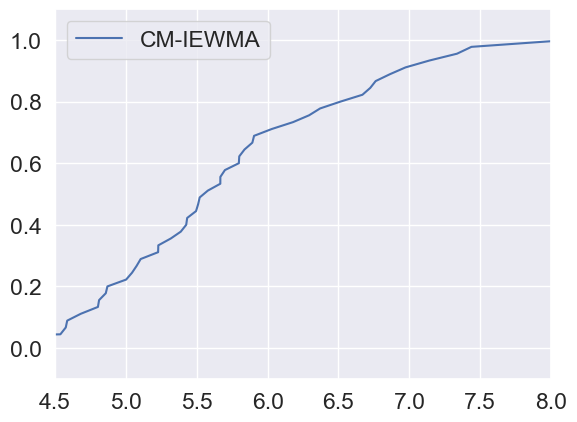

In [42]:
for name in log_likelihoods:
    if name != "PRESCIENT":
        data = regrets[name].resample("Q").mean().values
        x, y = ecdf(data)
        plt.plot(x, y, label=name)
plt.xlim(4.5,8)
plt.ylim(-0.1,1.1)
plt.legend();

### Regret metrics

In [44]:
print("\\begin{tabular}{lccccc}")
print("   \\toprule")
print("   Predictor & Average & Std.~dev. & Max \\\\")
print("   \\midrule")

for name in regrets:
    if name != "PRESCIENT":
        print("   {}".format(name), end=" & ")
        regret = regrets[name].resample("Q").mean()
        metrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        print("{} & {} & {} \\\\".format(metrics[0], metrics[1], metrics[2]))

print("   \\hline")
print("   PRESCIENT & 0.0 & 0.0 & 0.0 \\\\")
print("   \\bottomrule")
print("\\end{tabular}")


\begin{tabular}{lccccc}
   \toprule
   Predictor & Average & Std.~dev. & Max \\
   \midrule
   CM-IEWMA & 5.7 & 1.0 & 8.1 \\
   \hline
   PRESCIENT & 0.0 & 0.0 & 0.0 \\
   \bottomrule
\end{tabular}


# Mean variance portfolio optimization

In [45]:
from experiments.portfolio_backtests import *

# Risk-free rate for backtest period; for cash allocation end_date removed since
# it is removed in returns (in shift(-1)) to make predictors causal
rf = rf_rate.loc[start_date:end_date].iloc[:-1]

# Portfolio paramaters
additonal_cons={"short_lim":1.6, "upper_bound":0.15,\
             "lower_bound":-0.1}
sigma_tar = 0.1
excess = True

In [46]:
mean_predictors = [pd.DataFrame(predictor.mean).T for predictor in predictors]
cov_predictors = [predictor.covariance for predictor in predictors]

traders_mean_var = MeanVariance(returns, cov_predictors, names, mean_predictors=mean_predictors, start_date=start_date, end_date=end_date).backtest(additonal_cons, sigma_tar)

100%|██████████| 2/2 [00:20<00:00, 10.43s/it]


In [47]:
create_table(traders_mean_var, None, rf, excess)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   CM-IEWMA & 1.8\% & 11.3\% & 0.2 & 28\% \\
   \hline
   PRESCIENT & 73.0\% & 10.0\% & 7.3 & 3\% \\
   \bottomrule
\end{tabular}
